In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# ATTENTION: only run this once, otherwise the header will be appended multiple times

# def append_header(filename):
#     with open(filename, 'r') as original:
#         data = original.read()
#     with open(filename, 'w') as modified:
#         modified.write("stx_ident,count\n")
#         modified.write(data)

# append_header("mds/mds_catalogue.csv")

In [3]:
mds_catalogue = pd.read_csv("mds/mds_catalogue.csv")
# Add a cumulative sum column
mds_catalogue['cumsum'] = mds_catalogue['count'].cumsum()
mds_catalogue.head()

,stx_ident,count,cumsum
0,stx/stx/2017-04-16 17_00_00.npz,1,1
1,stx/stx/2017-08-15 15_30_00.npz,5,6
2,stx/stx/2017-07-17 22_30_00.npz,2,8
3,stx/stx/2017-07-26 23_30_00.npz,5,13
4,stx/stx/2017-03-25 00_30_00.npz,3,16


In [4]:
!mkdir -p mds/bystorm
!mkdir -p mds/bystormlabels

In [5]:
mds = np.load("mds/mds_pos.npz")['arr_0']

In [6]:
# Sample 1000 points from the MDS
sample = np.random.choice(mds.shape[0], 1000, replace=False)
sample_mds = mds[sample]

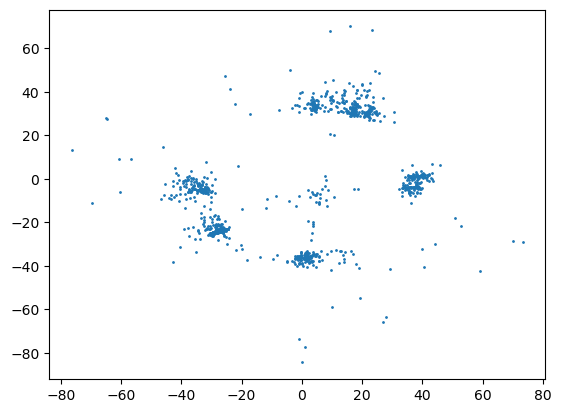

In [7]:
fig,ax = plt.subplots()
sc = plt.scatter(sample_mds[:,0], sample_mds[:,1], s=1)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join(list(map(str,ind["ind"]))))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)
    

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

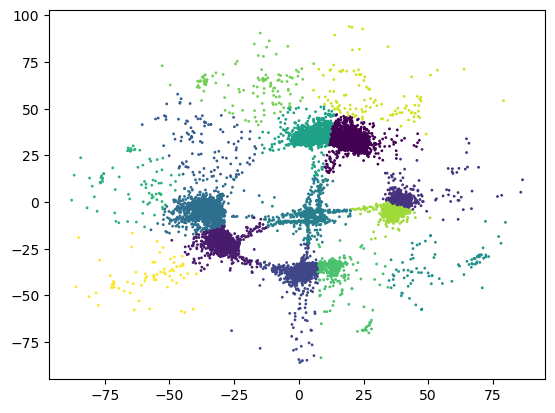

In [8]:
# We run the KMeans algorithm on the MDS data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(mds)
labels = kmeans.labels_

# Plot the clusters
fig,ax = plt.subplots()
sc = plt.scatter(mds[:,0], mds[:,1], s=1, c=kmeans.labels_)
plt.show()


In [9]:
# Save the labels to a file
np.savez_compressed("mds/mds_labels.npz", labels)

In [10]:
from tqdm import tqdm

# we iterate through the catalogue by rows
last_item_index = 0
for index, row in tqdm(mds_catalogue.iterrows(), total=mds_catalogue.shape[0]):
    next_item_index = row['cumsum']
    # we extract the mds points
    mds_points_for_this_storm = mds[last_item_index:next_item_index, :]
    labels_for_this_storm = kmeans.labels_[last_item_index:next_item_index]
    # save mds_points_for_this_storm to the file of the storm
    storm_name = row['stx_ident'].replace("stx/stx/", "").replace(".npz", "")
    np.savez_compressed("mds/bystorm/" + storm_name + ".npz", mds_points_for_this_storm)
    np.savez_compressed("mds/bystormlabels/" + storm_name + ".npz", labels_for_this_storm)
    last_item_index = row['cumsum']

  0%|          | 0/3680 [00:00<?, ?it/s]

100%|██████████| 3680/3680 [00:01<00:00, 3437.57it/s]


In [11]:
!tar -czf mds.tar.gz mds